In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../../../../')
print(os.getcwd())
from v2.strategy.indicators.optimal_v2 import Optimal_v2
from v2.model import Trading
from v2.strategy.indicators.param import Param
from v2.strategy.indicators.roc import RateOfChange
from v2.research.scripts.notebook_utils import notebookUtils
from v2.research.scripts.scoreboard import updateScoreboard
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

/home/marshingjay/Repos/moonshot/back_testing


In [2]:
nu = notebookUtils()
model_name = "kingmaker"

In [3]:
# dataset, features, indicators = nu.loadData(indicators=[('BOP', 'close', ''), ('PSAR', 'close', ''), ('JTI', 'SMA_close_period_1500', 'SMA15000'),('optimal_v2', 'close', '')],
#                             param_spec={},
#                             optimal_threshold={'buy':0.01},
                            
#                             spans=[
#                                     {'indicator_name':'natr',
#                                     'column_name': 'close',
#                                     'param_name': 'period',
#                                     'param_values': [30, 300]},
#                                     {'indicator_name':'cmo',
#                                     'column_name': 'close',
#                                     'param_name': 'period',
#                                     'param_values': [2, 10, 30, 200]},
#                                     {'indicator_name':'sma',
#                                     'column_name': 'close',
#                                     'param_name': 'period',
#                                     'param_values': [60, 1500]},
                                    
#                                     ],

#                             scale='minmaxwindow')

dataset, features, indicators = nu.loadData(indicators=[('BOP', 'close', ''), ('PSAR', 'close', ''), ('optimal_v2', 'close', '')],
                            param_spec={},
                            optimal_threshold={'buy':(0.01,0.02)},
                            
                            spans=[
                                    {'indicator_name':'natr',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [30, 300]},
                                    
                                    {'indicator_name':'cci',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [10, 30, 200]},
                                    {'indicator_name':'willr',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [10, 30, 200]},
                                    
                                    ],

                            scale='minmaxwindow')

        
    # create one minute, five minute, ten minute, and twenty minute slopes for macd, rsi




Loading data from BTC...
Loading data from chunk 0...
Loading data from chunk 1...
Loading data from chunk 2...
Loading data from chunk 3...
Loading data from chunk 4...
Loading data from chunk 5...
Loading data from chunk 6...
Loading data from chunk 7...
Loading data from chunk 8...
Loading data from chunk 9...
Loading data from chunk 10...


In [4]:
dataset.drop(["time", "open", "high", "volume", "low",], axis=1, inplace=True)

dataset.dropna(inplace=True)


In [5]:
trainX, testX, trainy, testy = nu.splitData(dataset, split_size=0.2, y_column_name="optimal", shuffle_data=False, balance_unbalanced_data=True, balance_info={'multiplier_val':64, 'superset_class_val':0, 'randomize_concat':True})
len(trainX)

146315

In [6]:
class_weights = nu.getWeights(trainy)
class_weights

{0: 0.5078125, 1: 32.5}

In [7]:
features

['BOP',
 'PSAR',
 'NATR_close_period_30',
 'NATR_close_period_300',
 'CCI_close_period_10',
 'CCI_close_period_30',
 'CCI_close_period_200',
 'WILLR_close_period_10',
 'WILLR_close_period_30',
 'WILLR_close_period_200']

In [8]:
clf = RandomForestClassifier(random_state=69420, class_weight=class_weights, n_jobs=-1, n_estimators=100, criterion='entropy', min_samples_leaf=5)
clf.fit(trainX.drop("close", axis=1).values, trainy.values)
print(clf.score(testX.drop("close", axis=1).values, testy.values))



0.9981710261645924




feature_importances = permutation_importance(clf, trainX.drop("close", axis=1).values, trainy.values, n_repeats=10, random_state=69420)

for i in range(len(feature_importances.importances_mean)):
    print('i: {}, Feature: {}, Score: {}'.format(i, trainX.drop("close", axis=1).columns[i], feature_importances.importances_mean[i]))

In [118]:
reduced_classified_data = nu.classifyPoints([clf], testX, predict_proba=True, proba_thresh=[0.5], plot_optimal=True, optimal=testy)

In [119]:
smaller_view_data = reduced_classified_data
smaller_view_data.reset_index(inplace=True)

<Figure size 432x288 with 0 Axes>

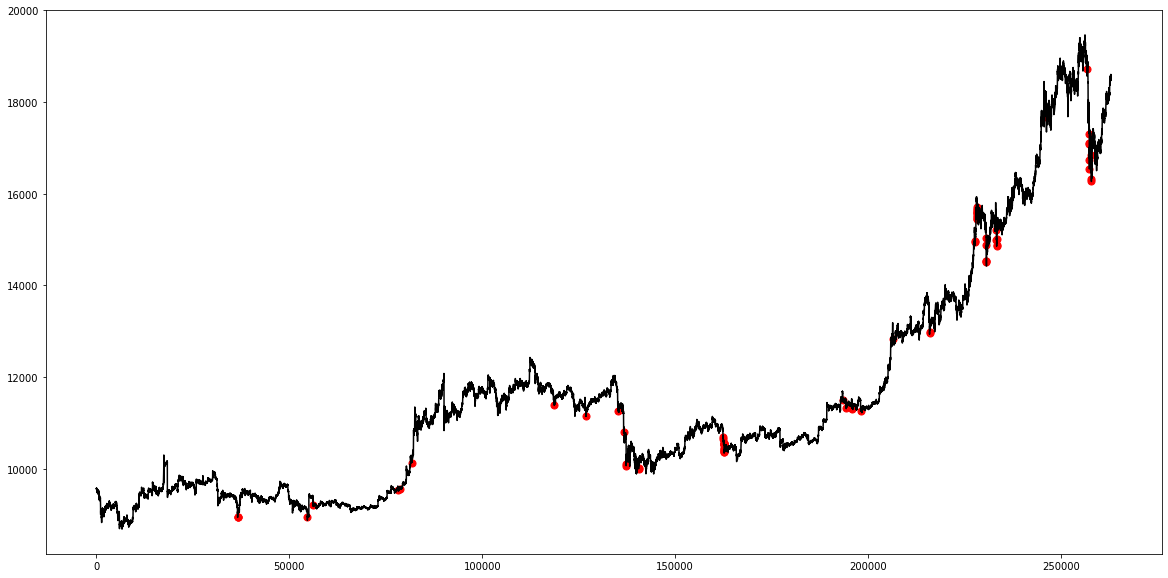

In [120]:
nu.graphPoints(smaller_view_data, mode="buy", plot_optimal=False)

In [125]:
model_version = nu.exportModel(clf, model_name, new_version=False, indicators=indicators, features=features, proba_threshold=0.5, is_nn=False)

In [122]:
# score, trades = nu.testModel(model_name)

In [123]:
# updateScoreboard(model_name, model_version, score, trades, features)

In [124]:
#1.5 is the best one. XGBoost with no time features
#1.6 is next one with RF and time features